In [69]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Setting up DataFrames

In [70]:
aisles, products, departments, orders = pd.read_csv('aisles 5.csv'), pd.read_csv('products.csv'), pd.read_csv('departments.csv'), pd.read_csv('order_products.csv')
orders = orders.merge(products[['product_id', 'aisle_id', 'department_id']], on='product_id', how='left')

#### Graphing sales by department

In [71]:
# Barplot function
sns.set_palette(['royalblue', 'darkorange'])

def bar_plot(data, cats, var, label, title, axs, rot=45, pct=False):
    if not pct:
        axs.bar(data[cats], data[var], label=label)
        axs.set_title(title)
        axs.set_xticks(data[cats])
        axs.set_xticklabels(data[cats], rotation=rot, ha='right')
    
    if pct:
        axs.bar(data[cats], 1-data[var], bottom=data[var])
        axs.bar(data[cats], data[var], label=label)
        axs.set_title(title)
        axs.set_xticks(data[cats])
        axs.set_xticklabels(data[cats], rotation=rot, ha='right')
    axs.legend()

/tmp/ipykernel_353931/3311092380.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  deptsales = pd.DataFrame(orders.groupby('department_id').apply(lambda x: pd.Series([len(x), sum(x['reordered'])])).reset_index().rename(columns={0: 'sale_count', 1: 'reorder_count'}).sort_values(by='sale_count', ascending=False))


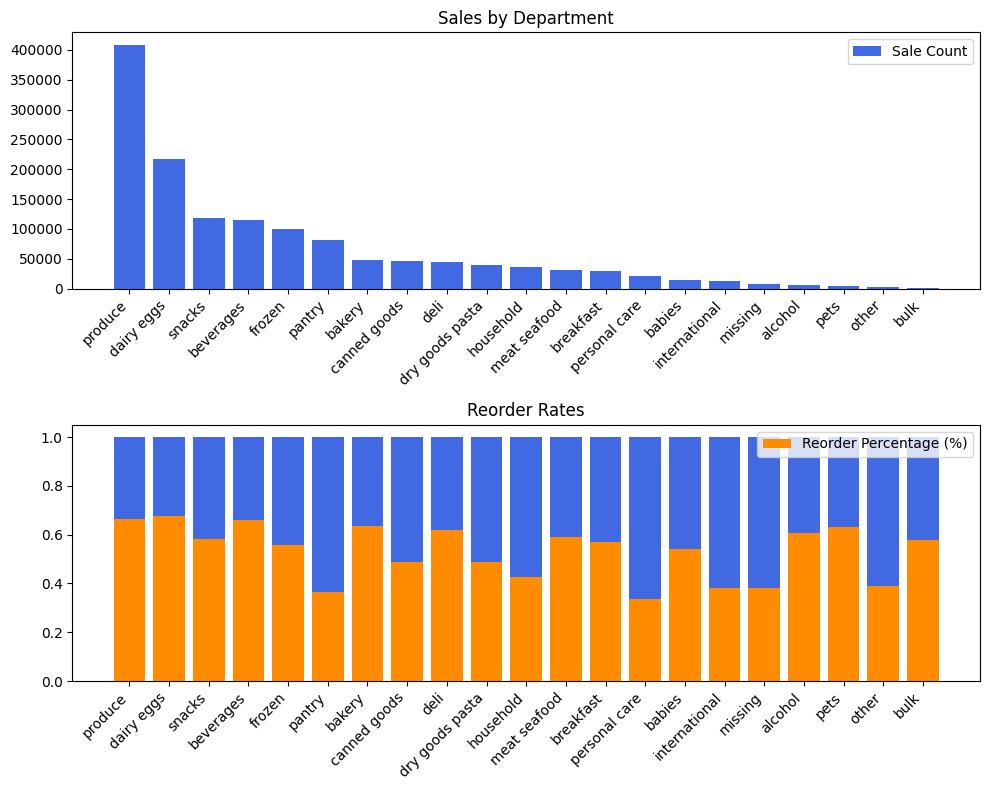

In [72]:
deptsales = pd.DataFrame(orders.groupby('department_id').apply(lambda x: pd.Series([len(x), sum(x['reordered'])])).reset_index().rename(columns={0: 'sale_count', 1: 'reorder_count'}).sort_values(by='sale_count', ascending=False))
deptsales['reorder_pct'] = deptsales['reorder_count'] / deptsales['sale_count']
deptsales = deptsales.merge(departments, on='department_id', how='left')

fig, axs = plt.subplots(nrows=2, figsize=(10,8)); axs = axs.flatten()
bar_plot(deptsales, 'department', 'sale_count', 'Sale Count', 'Sales by Department', axs[0])
bar_plot(deptsales, 'department', 'reorder_pct', 'Reorder Percentage (%)', 'Reorder Rates', axs[1], pct=True)
plt.tight_layout()

/tmp/ipykernel_353931/1301673438.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aislesales = pd.DataFrame(orders.groupby('aisle_id').apply(lambda x: pd.Series([x['department_id'].values[0], len(x)])).reset_index().rename(columns={0: 'department_id', 1: 'sale_count'}).sort_values(by='sale_count', ascending=False))


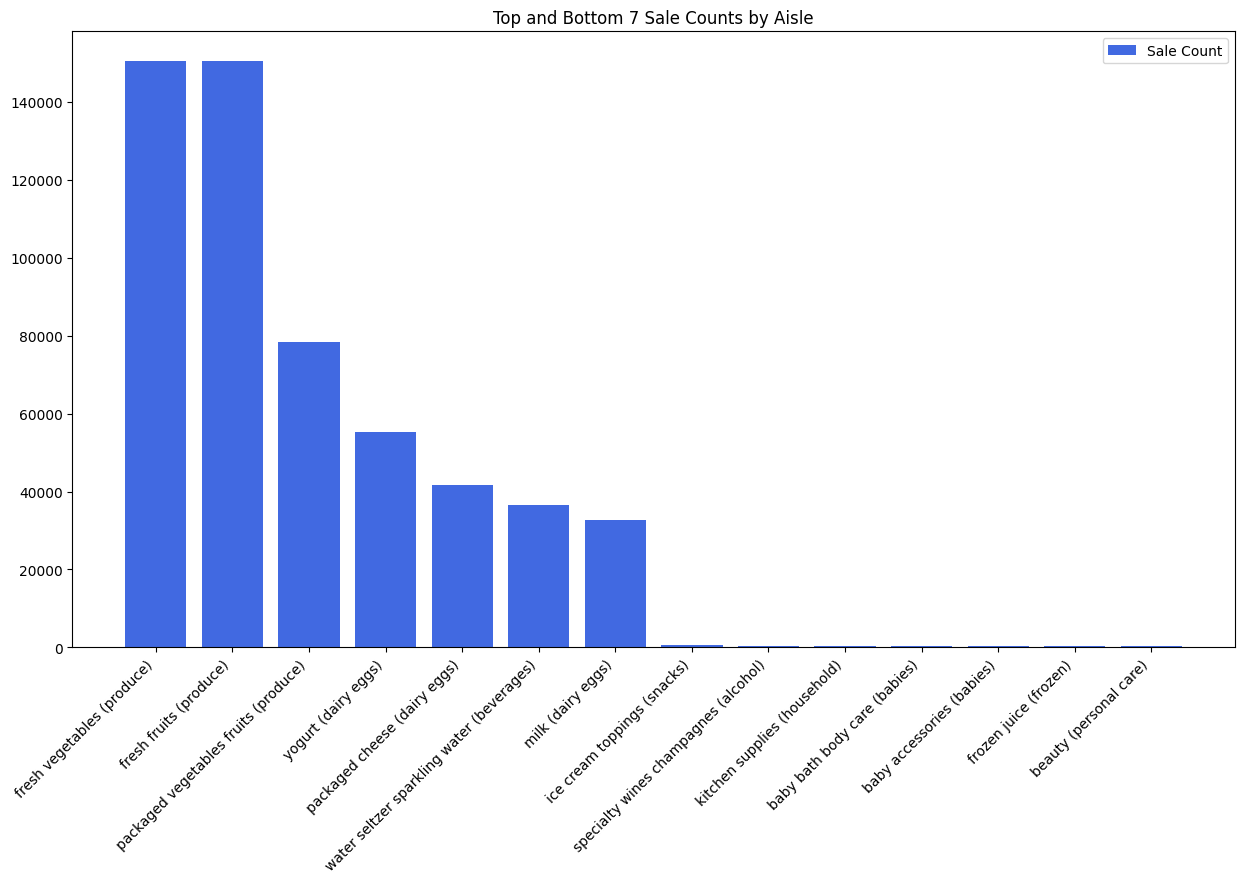

In [73]:
aislesales = pd.DataFrame(orders.groupby('aisle_id').apply(lambda x: pd.Series([x['department_id'].values[0], len(x)])).reset_index().rename(columns={0: 'department_id', 1: 'sale_count'}).sort_values(by='sale_count', ascending=False))
aislesales = aislesales.merge(aisles, on='aisle_id', how='left')
aislesales = aislesales.merge(departments, on='department_id', how='left')
numberaisles = 7
mostleast = pd.concat([aislesales[:numberaisles], aislesales[-numberaisles:]])
mostleast['labels'] = mostleast[['aisle', 'department']].apply(lambda x: f"{x['aisle']} ({x['department']})", axis=1)

fig, axs = plt.subplots(figsize=(15,8))
bar_plot(mostleast, 'labels', 'sale_count', 'Sale Count', f'Top and Bottom {numberaisles} Sale Counts by Aisle', axs)
plt.show()

There is lots of overlap between the produce and dairy/eggs departments and the most sold aisles. Worst aisles don't necessarily have the worst aisles. This most likely means they have few, strong aisles.

#### Correlations between department sales in the same basket

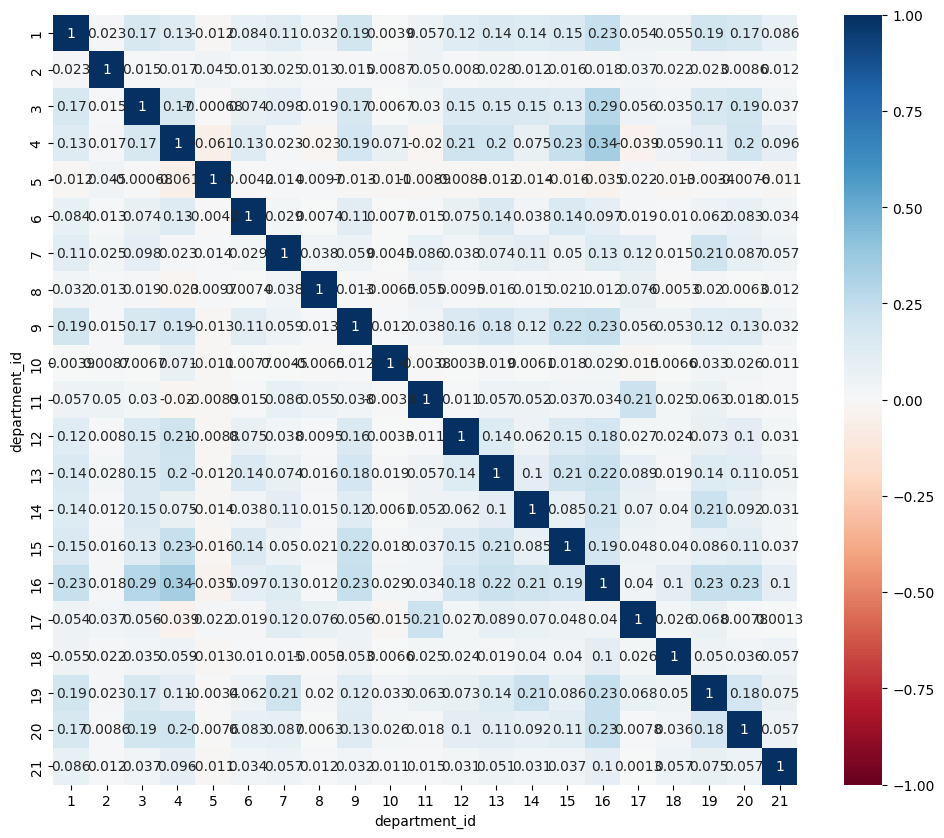

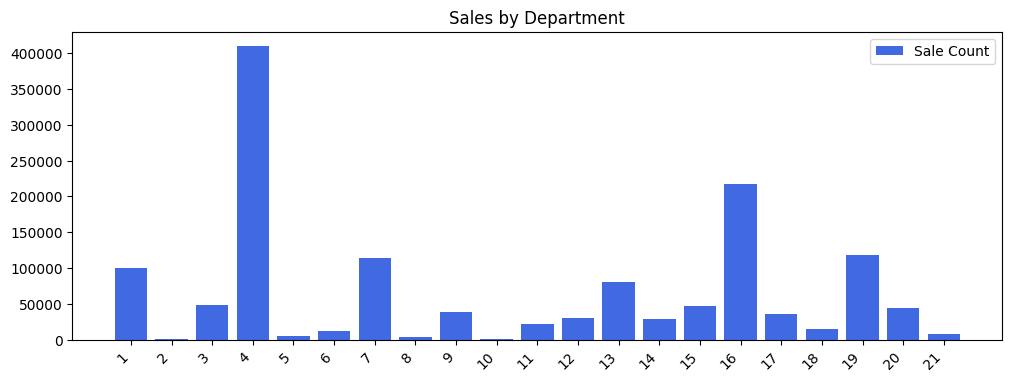

In [74]:
dept_counts = orders.groupby(['order_id', 'department_id']).size().reset_index(name='count')
corrs = dept_counts.pivot(index='order_id', columns='department_id', values='count').fillna(0).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corrs, annot=True, cmap='RdBu', vmin=-1, vmax=1, center=0)
plt.show(); fig,axs = plt.subplots(figsize=(12,4))
bar_plot(deptsales, 'department_id', 'sale_count', 'Sale Count', 'Sales by Department', axs)

Most strong correlations are directly proportional in size the the actual sales by the departments. This means they show up in the same basket not because there exist causality between the two (cross-selling), but rather because they are just bought so frequently.

Other correlations, like between departments 11 and 17, actually have some meaning as they aren't frequently sold departments. Despite this, they do show up in the same baskets a decent amount together. This is an actually interpretable (and likely actionable) insight.

Other departments that also follow this idea are: 3 & 9, 9 & 12, 9 & 15.

### Forecasting orders for a given department

In [75]:
dept5 = orders[orders['department_id'] == 5].copy()
dept5basketcounts = dept5.groupby('order_id').size().reset_index().rename(columns={0: 'item_count'})

# Using a 15-basket rolling window to aggregate and hopefully smooth over the sales numbers.
basketrolling15sum = dept5basketcounts.rolling(window=15, step=15).sum().dropna()

Text(0.5, 0, 'Group ID')

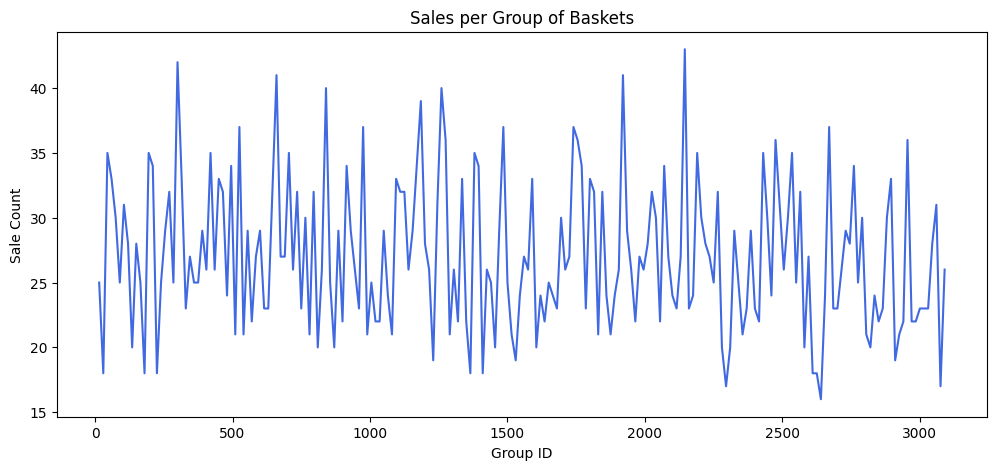

In [76]:
fig, axs = plt.subplots(figsize=(12,5))
sns.lineplot(basketrolling15sum['item_count']); axs.set_ylabel('Sale Count'); axs.set_title('Sales per Group of Baskets'); axs.set_xlabel('Group ID')

If directly forecasting this new series, as of now the best predictor seems to be previous values, as there is nothing else to predict with. Maybe add a time trend? The data seems to be random noise, would likely do nothing but slightly lower forecasted result as it seems to be trending slightly downwards.

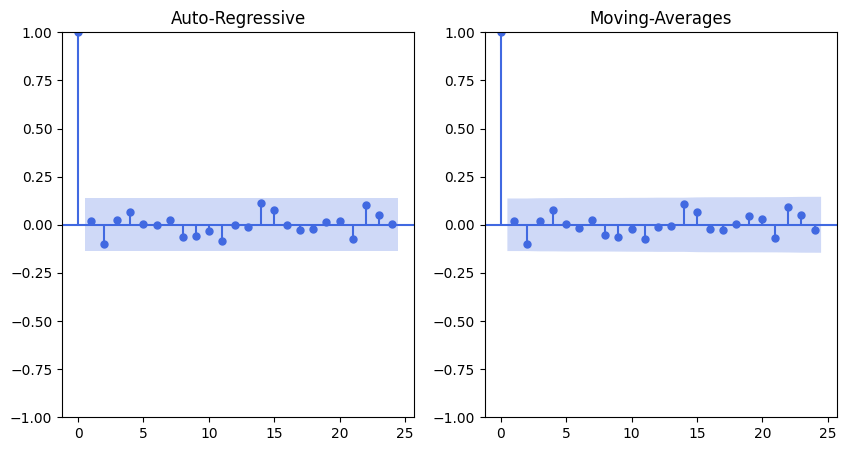

In [77]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
plot_pacf(basketrolling15sum['item_count'], ax=axs[0], title='Auto-Regressive');
plot_acf(basketrolling15sum['item_count'], ax=axs[1], title='Moving-Averages');

Two lag variable/moving average seems good to include.

In [78]:
model = ARIMA(basketrolling15sum['item_count'], order=(2,0,2))
model = model.fit()

/home/nazook/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/nazook/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/nazook/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


/home/nazook/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/nazook/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/nazook/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


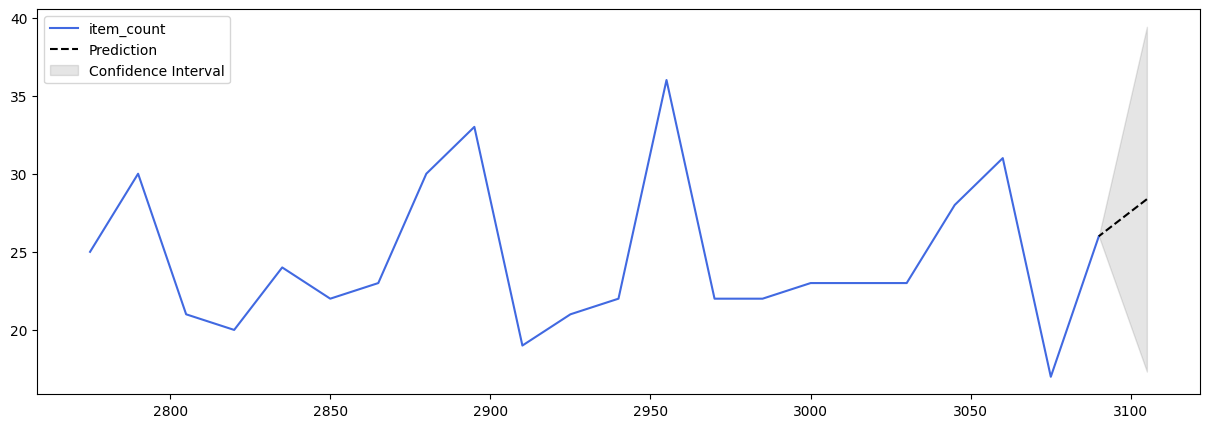

In [79]:
fig, ax = plt.subplots(figsize=(15, 5))

basketrolling15sum.loc[2775:, 'item_count'].plot(ax=ax)

forecast = model.get_forecast(steps=1, alpha=0.05).summary_frame()
forecast = pd.concat([forecast, pd.DataFrame({'mean':26, 'mean_se':0, 'mean_ci_lower':26, 'mean_ci_upper':26}, index=[3090])])
forecast.index = [3105,3090]
forecast['mean'].plot(ax=ax, style='k--', label='Prediction')
ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1, label='Confidence Interval');
ax.legend()

The prediction and resulting confidence interval predicts that the next rolling-window of 15 baskets will sell ~28 products, plus or minus 11. Not too good of a prediction using this method. Absent the presence of more data with time labels, this is the best we can do.

### Additional Insights Available from the Data.

As the data contains sequential purchase histories, we can use it to determine the most frequently connected departments, and use that to validate a sequential recommendation algorithm that will hopefully boost average order value (AOV).

Directionally connected departments:

In [80]:
deptchanges = orders.copy()
deptchanges['department_id_prev'] = deptchanges.groupby('order_id')['department_id'].shift(1)
deptchanges.dropna(subset=['department_id_prev'], inplace=True)
deptchanges = deptchanges[deptchanges['department_id_prev'] != deptchanges['department_id']]
counts = deptchanges.groupby(['department_id_prev', 'department_id']).size().reset_index().rename(columns={'department_id_prev':'from', 'department_id':'to', 0:'value'})
mapper = dict(zip(departments['department_id'], departments['department']))
counts = pd.DataFrame(counts)
counts1000 = counts[counts['value'] > 1000].copy()
nodelist = pd.DataFrame({'id':counts1000['from'].unique().astype(str), 'label':counts1000['from'].map(mapper).unique()})

In [81]:
import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.rinterface as rinterface
pandas2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R -i counts,nodelist

library('visNetwork')
library('igraph')
library('dplyr')

#Nodes
nodes <- as.data.frame(nodelist)
colnames(nodes) <- c('id', 'label')
nodes$color <- rainbow(length(nodes[1]))

#Edges
edges <- as.data.frame(counts)
colnames(edges) <- c('from', 'to', 'value')

visNetwork(nodes, edges, height = "1440px", width = "2560px") %>%
  visIgraphLayout() %>%
  visEdges(smooth = TRUE) %>%
  visNodes(font = list(size = 24, color = "black")) %>%
  visPhysics(enabled=FALSE) %>%
  visOptions(selectedBy = "label", 
             highlightNearest = TRUE, 
             nodesIdSelection = TRUE)


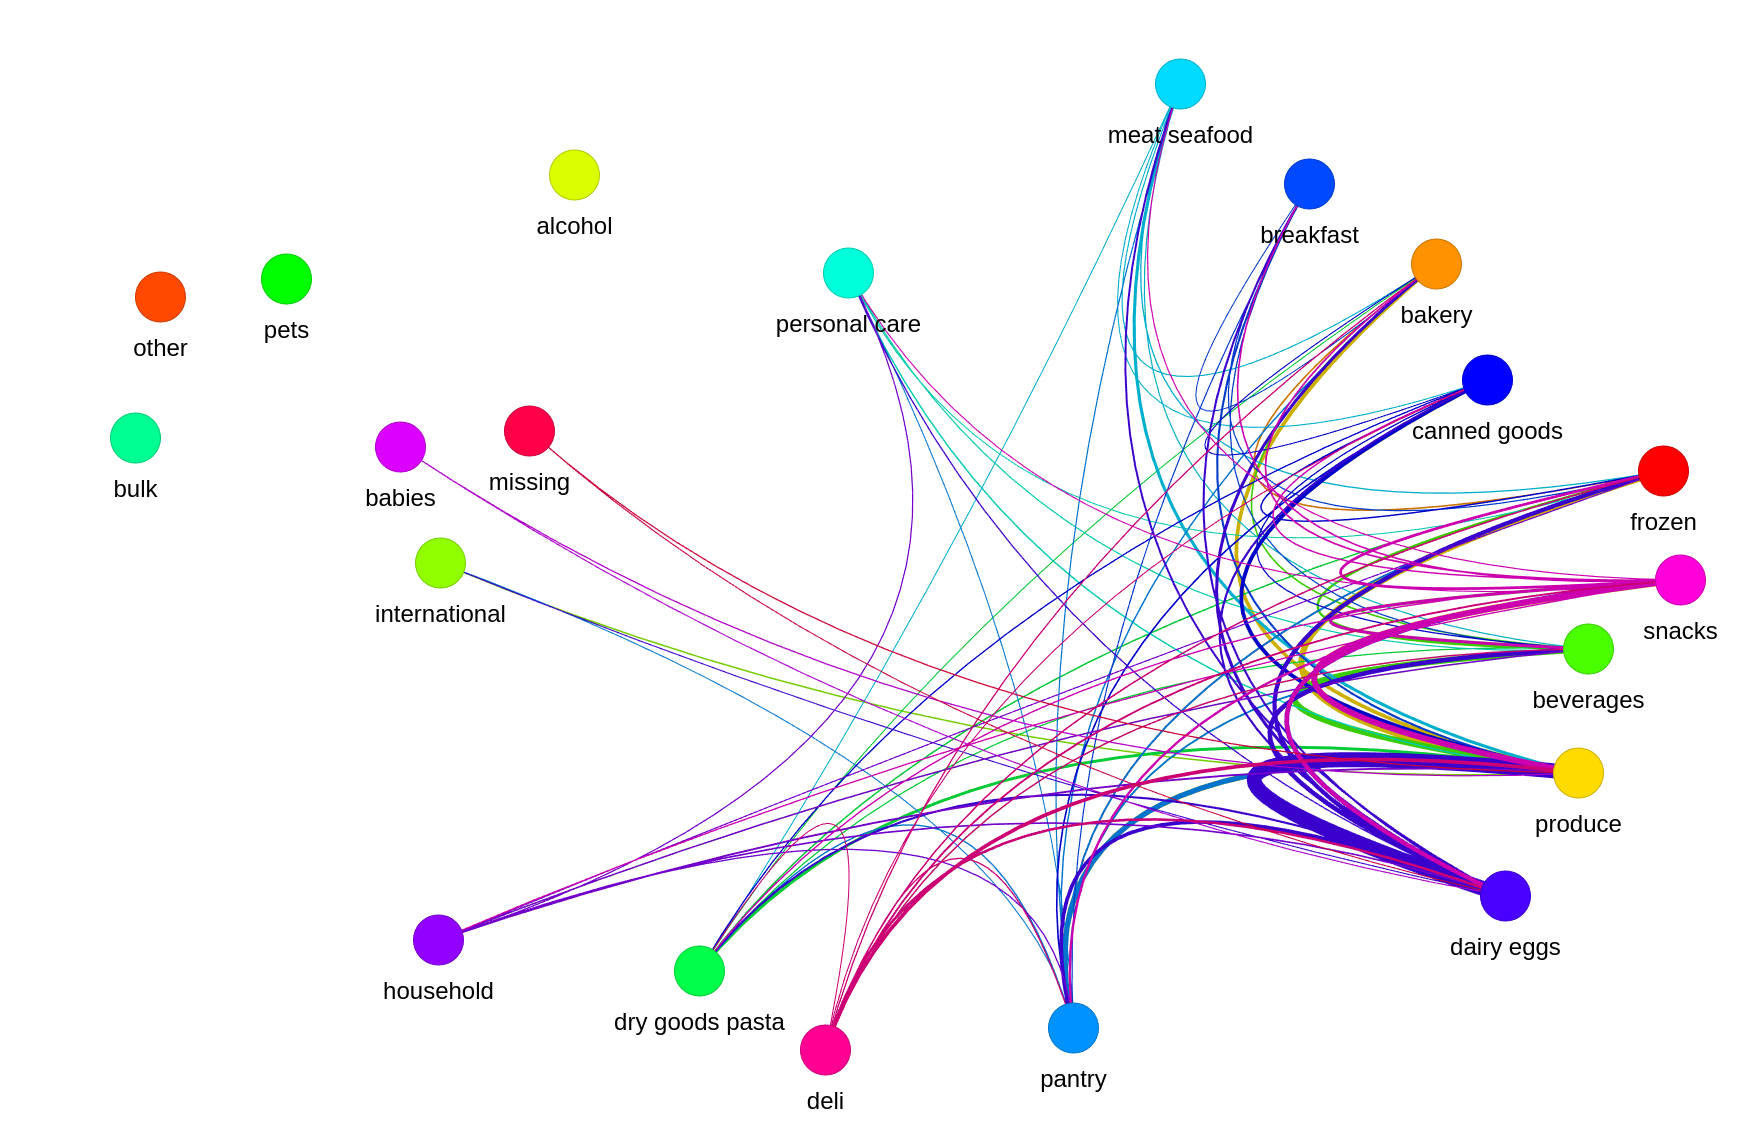

Each line represent 1000 people moving between departments.

Lots of department traffic between produce and dairy/eggs, as well as snacks, beverages, and frozen. Expected as they're the most sold departments.

### Recommendation Algorithm

There are multiple models that can be used to build recommendation systems. I believe the model for this task falls under the Retreival category. Here, baskets can be embedded by the initial sequence of products they contain (context), and the task can be to recommend the last product that was purchased (target). This gives us a prediction measure that we can test the accuracy of. This result if accurate is extremely useful when designing a product recommendation algorithm (which this is) and can lead to targeted item recommendations resulting in increased average order value per basket (and subsequent fees earned by Instacart). In this case because we are modeling sequential purchases we will be using a Gated Recurrent Unit (GRU) to convert the context embeddings into one embedding for the entire basket that can be multiplied against the target embedding matrix to achieve our recommendations.

Tensorflow has a recommenders library that is very well suited for building robust recommendation models, and provides many Retrieval models.

Implementation guide on a semi-similar example:
https://www.tensorflow.org/recommenders/examples/sequential_retrieval

In [83]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow as tf
import tensorflow_recommenders as tfrs

# Only keeping baskets with 2 or more observations. Need at least 1 context item.
valid_baskets = orders.groupby('order_id').filter(lambda x: len(x) > 1)

# Setting up an irregular tensor by using values and row_ids instead of passing the raw series as a dataset.
values = valid_baskets['product_id'].astype(str).tolist()
row_ids = valid_baskets['order_id'].factorize()[0]

ragged_tensor = tf.RaggedTensor.from_value_rowids(
    values=tf.constant(values),
    value_rowids=tf.constant(row_ids)
)

# Splitting the irregular tensor into context and target items.
contexts = ragged_tensor[:, :-1].to_tensor('0')
targets = ragged_tensor[:, -1:].to_tensor()

# Finally making the dataset
dataset = tf.data.Dataset.from_tensor_slices({
    'context': contexts,
    'target': targets})

# Shuffling the data and splitting into training and testing sets
tf.random.set_seed(29)
shuffled = dataset.shuffle(len(dataset))
train = shuffled.take(int(0.8 * len(dataset))).batch(128).cache()
test = shuffled.skip(int(0.8 * len(dataset))).take(int(0.2 * len(dataset))).batch(128).cache()

# Setting up the vocabulary for the model 
unique_items = valid_baskets['product_id'].unique()
unique_items = [str(product) for product in unique_items]

In [84]:
# Setting up a class object for the model to make fine-tuning easier.
class ProductRecommendationModel(tfrs.Model):
    def __init__(self, unique_product_ids, embedding_dim=32):
        super().__init__()
        # Embedding/Processing unit for the context.
        self.sequence_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_product_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_product_ids) + 1, embedding_dim, mask_zero=True),
            tf.keras.layers.GRU(embedding_dim)
        ])

        # Embedding unit for the target.
        self.product_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_product_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_product_ids) + 1, embedding_dim)
        ])

        # Defined metrics to measure. 
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=tf.data.Dataset.from_tensor_slices(unique_product_ids).batch(128).map(self.product_model)
            )
        )
    
    def compute_loss(self, features, training=False):
        context_embedding = self.sequence_model(features['context'])
        target_embedding = self.product_model(features['target'])

        return self.task(context_embedding, target_embedding, compute_metrics=not training)

In [87]:
model = ProductRecommendationModel(unique_items, embedding_dim=64)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

if os.path.exists('recmodel_weights.index'):
    model.load_weights('recmodel_weights')
else:
    model.fit(train, epochs=20)
    model.save_weights('recmodel_weights')

Epoch 1/20
778/778 [==============================] - 73s 89ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 592.1928 - regularization_loss: 0.0000e+00 - total_loss: 592.1928
Epoch 2/20
778/778 [==============================] - 68s 88ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 534.9713 - regularization_loss: 0.0000e+00 - total_loss: 534.9713
Epoch 3/20
778/778 [==============================] - 89s 114ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 -

In [88]:
model.evaluate(test, return_dict=True)

175/195 [=========================>....] - ETA: 5s - factorized_top_k/top_1_categorical_accuracy: 0.1572 - factorized_top_k/top_5_categorical_accuracy: 0.4575 - factorized_top_k/top_10_categorical_accuracy: 0.5416 - factorized_top_k/top_50_categorical_accuracy: 0.6815 - factorized_top_k/top_100_categorical_accuracy: 0.7267 - loss: 283.6997 - regularization_loss: 0.0000e+00 - total_loss: 283.6997

195/195 [==============================] - 55s 273ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1573 - factorized_top_k/top_5_categorical_accuracy: 0.4576 - factorized_top_k/top_10_categorical_accuracy: 0.5413 - factorized_top_k/top_50_categorical_accuracy: 0.6813 - factorized_top_k/top_100_categorical_accuracy: 0.7265 - loss: 280.9153 - regularization_loss: 0.0000e+00 - total_loss: 280.9153


{'factorized_top_k/top_1_categorical_accuracy': 0.15732550621032715,
 'factorized_top_k/top_5_categorical_accuracy': 0.45762303471565247,
 'factorized_top_k/top_10_categorical_accuracy': 0.5412511825561523,
 'factorized_top_k/top_50_categorical_accuracy': 0.6813284158706665,
 'factorized_top_k/top_100_categorical_accuracy': 0.7264795899391174,
 'loss': 53.52682113647461,
 'regularization_loss': 0,
 'total_loss': 53.52682113647461}

Top_K accuraccy measures how often the targets actual purchase was within the products recommended/ranked highest by the algorithm.

Pretty promising performance metrics for the model. A perfect recommendation accuracy of 15% seems very good as a starting point for a recommendation algorithm.

#### Example predictions

In [89]:
def get_recommendations(model, basket:list, top_k=10, scores=False):
    example_basket = pd.DataFrame(basket, columns=['product_name'])

    example_basket['product_id'] = example_basket['product_name'].map(dict(zip(products['product_name'], products['product_id'])))
    context = tf.convert_to_tensor([example_basket['product_id'].astype(str).tolist()])
    context_embedding = model.sequence_model(context)

    target_product_ids = tf.convert_to_tensor(unique_items, dtype=tf.string)  # All unique product IDs
    target_embeddings = model.product_model(target_product_ids)

    rankings = tf.linalg.matmul(context_embedding, target_embeddings, transpose_b=True)

    top_k_indices = tf.math.top_k(rankings, k=top_k).indices
    top_k_scores = tf.math.top_k(rankings, k=top_k).values

    recommended_product_ids = tf.gather(unique_items, top_k_indices[0]).numpy()
    recommended_products = pd.DataFrame([int(x.decode('utf-8')) for x in recommended_product_ids], columns=['product_id'])['product_id'].map(dict(zip(products['product_id'], products['product_name'])))

    if scores:
        return(recommended_products, top_k_scores)
    else:
        return(recommended_products)

In [90]:
get_recommendations(model, ['Sour Cream', 'Organic Flour Tortillas', 'Organic  Monterey Jack Cheese'])

0                        Roasted Salted Peanuts
1                    Lemon Fruit & Nut Food Bar
2       Wild Sardines in Extra Virgin Olive Oil
3    Lemongrass Citrus Scent Disinfecting Wipes
4           French Vanilla Coconut Milk Creamer
5            Gluten Free Crunchy Vanilla Cereal
6                            Grilled Vegetables
7       Organic Strawberry Yogurt & Fruit Snack
8            100% Premium Arabica Ground Coffee
9      Apple Cinnamon With Flax Instant Oatmeal
Name: product_id, dtype: object

In [92]:
get_recommendations(model, ['Kitchen Scrubber Sponge', '8 X 6 Cutting Board', 'Stainless Steel Strainer', 'Clear Hand Soap', '4 Inch Paring Knife'])

0                  Organic Lactose Free 1% Lowfat Milk
1                                        Mesclun Salad
2                                 Organic Genoa Salami
3                                           Corn Flour
4                       Organic Ice Cream Vanilla Bean
5    Direct Trade Black Cat Classic Espresso Roast ...
6                                         Caster Sugar
7                              Organic Hazelnut Spread
8                     Organic Raw Multigreen Kobmbucha
9           Organic & Raw Strawberry Serenity Kombucha
Name: product_id, dtype: object

#### Limitations

The model is trained on ██████████'s consumer data which is heavily grocery-related. There is no surprise therefore when most of the recommendations are mostly grocery-related, even when the basket items do not seem to have a grocery pattern within them. The model is overfit by default, as the data is heavily weighed towards grocery purchases.

The way to fix this issue is to train on a much larger and more diverse dataset that covers all store departments equally, as well as increasing the complexity and training time of the model. Segmenting this current dataset to create uniform department sales would likely reduce the data to a point where any model would fit itself to sample-specific noise rather than large, overarching relationships between the items. More data is needed.